In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from datetime import date

In [3]:
st = st.Stocks()

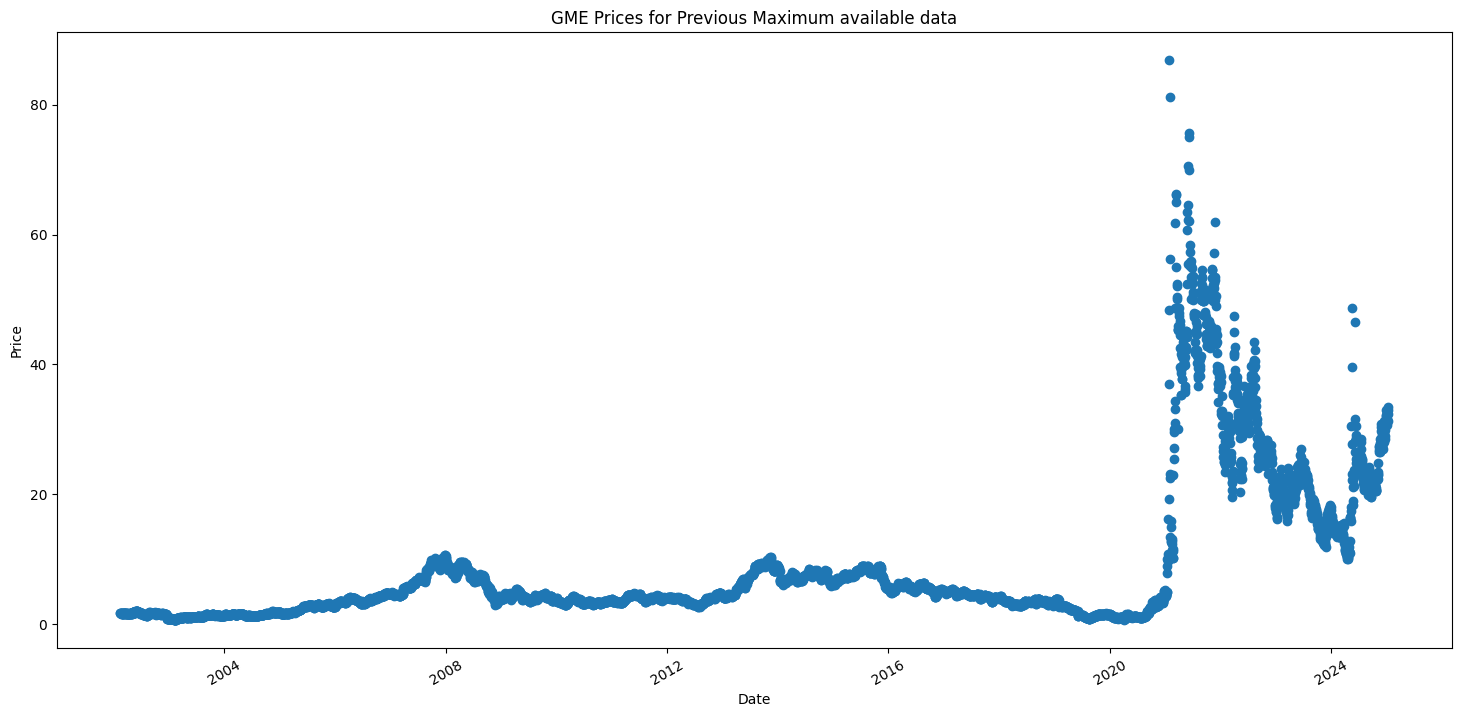

Closing price as of 2025-01-13: $31.31
The percentage change over previous Maximum available data is 1833%
Dividends total $2.39
Stock Splits total $6.0
'Capital Gains' not found in data


In [4]:
df = st.stats_generator('gme')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620128,1.693350,1.603296,1.691667,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716074,1.670626,1.683250,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683250,1.687458,1.658002,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578047,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615920,1.662209,1.603295,1.662209,6892800,0.0,0.0


### -- Without Winsorization --

In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
# format new dataset for model with 'ds' and 'y' for prophet model

df_train = df[['Date', 'Close']]
df_train = df_train.rename(columns={'Date': 'ds', 'Close': 'y'})

In [8]:
# set training period
train_period = 365 * 4
df_train = df_train[-train_period:] 

# set forecast period
predict_period = 365

In [9]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_overall_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-predict_period:]
    y_pred = forecast['yhat'][-predict_period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [10]:
# create baseline model

m1 = Prophet()
m1.fit(df_train)

11:23:15 - cmdstanpy - INFO - Chain [1] start processing
11:23:15 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# create cross_validation function for reusability

def cv_func(model_name):
    return cross_validation(model_name, initial=f'{train_period} days', period='365 days', horizon = '365 days')

In [13]:
%%time

# create baseline model

m1 = Prophet()
m1.fit(df_train)

# Get cv metrics
df_cv = cv_func(m1)
df_p = performance_metrics(df_cv)
print(pd.DataFrame(df_p.mean()).T)
period = predict_period

future = m1.make_future_dataframe(periods=period)
forecast = m1.predict(future)

get_overall_accuracy(df_train.y, forecast)

11:23:38 - cmdstanpy - INFO - Chain [1] start processing
11:23:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

11:23:38 - cmdstanpy - INFO - Chain [1] start processing
11:23:39 - cmdstanpy - INFO - Chain [1] done processing


                       horizon         mse       rmse        mae      mape  \
0  198 days 20:55:13.274336284  188.787367  12.241369  11.649842  0.501718   

      mdape     smape  coverage  
0  0.507299  0.717322  0.384956  
CPU times: user 305 ms, sys: 54.3 ms, total: 359 ms
Wall time: 773 ms


,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,12.928713,0.795689,200.93046,14.174994


In [14]:
# # get interactive visual

# # Plot Forecast
fig1 = plot_plotly(m1, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price', 
                   xaxis_title='Date',
                   width=1500
                   )
# # Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### -- With Winsorization --

In [15]:
def dynamic_winsorize(df, column, window_size=30, percentiles=(0.05, 0.95)):
    """
    Winsorizes data within a rolling window.

    Args:
        df: DataFrame containing the data.
        column: Name of the column to winsorize.
        window_size: Size of the rolling window.
        percentiles: Tuple containing the lower and upper percentiles.

    Returns:
        DataFrame with the winsorized column.
    """

    df['rolling_lower'] = df[column].rolling(window=window_size).quantile(percentiles[0])
    df['rolling_upper'] = df[column].rolling(window=window_size).quantile(percentiles[1])

    df['winsorized'] = df[column]
    df.loc[df[column] < df['rolling_lower'], 'winsorized'] = df['rolling_lower']
    df.loc[df[column] > df['rolling_upper'], 'winsorized'] = df['rolling_upper']

    return df

# Apply dynamic winsorization
df = dynamic_winsorize(df, 'Close')

In [16]:
# format new dataset for model with 'ds' and 'y' for prophet model

df_train = df[['Date' ,'Close', 'winsorized']]
df_train = df_train.rename(columns={'Date': 'ds', 'winsorized': 'y'})

In [17]:
# set training period
train_period = 365 * 4
df_train = df_train[-train_period:] 

# set forecast period
predict_period = 365

In [18]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_overall_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-predict_period:]
    y_pred = forecast['yhat'][-predict_period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [19]:
# create baseline model

m1 = Prophet()
m1.fit(df_train)

11:24:25 - cmdstanpy - INFO - Chain [1] start processing
11:24:25 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# create cross_validation function for reusability

def cv_func(model_name):
    return cross_validation(model_name, initial=f'{train_period} days', period='365 days', horizon = '365 days')

In [21]:
%%time

# create baseline model

m1 = Prophet()
m1.fit(df_train)

# Get cv metrics
df_cv = cv_func(m1)
df_p = performance_metrics(df_cv)
print(pd.DataFrame(df_p.mean()).T)
period = predict_period

future = m1.make_future_dataframe(periods=period)
forecast = m1.predict(future)

get_overall_accuracy(df_train.Close, forecast)

11:24:33 - cmdstanpy - INFO - Chain [1] start processing
11:24:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

11:24:33 - cmdstanpy - INFO - Chain [1] start processing
11:24:33 - cmdstanpy - INFO - Chain [1] done processing


                       horizon         mse       rmse        mae      mape  \
0  198 days 20:55:13.274336284  183.875628  11.994739  11.623983  0.506034   

      mdape     smape  coverage  
0  0.509734  0.729943  0.314159  
CPU times: user 342 ms, sys: 73.9 ms, total: 416 ms
Wall time: 933 ms


,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,12.551067,0.773831,191.059644,13.822433


In [ ]:
# # get interactive visual

# # Plot Forecast
fig1 = plot_plotly(m1, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price', 
                   xaxis_title='Date',
                   width=1500
                   )
# # Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1